In [7]:
# RESNET18
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
print(os.listdir("/content/drive/MyDrive"))


['Datasets']


In [10]:
import torch

print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

assert torch.cuda.is_available(), "GPU KAPALI!"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



CUDA: True
GPU: Tesla T4
Device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import cv2
from PIL import Image
import os
import shutil
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns


# RESNET18 İÇİN ŞEMA
# Input Image (RGB, 224 × 224 × 3)
#         │
# Resize + Normalize (ImageNet)
#         │
# ────────────────────────────────
# Initial Convolution
# • 7×7 Conv, 64 filters
# • BatchNorm + ReLU
# • MaxPooling
# Output: 56 × 56 × 64
# ────────────────────────────────
#         │
# Residual Block Group 1
# • 2 × BasicBlock
# • Skip (Residual) Connections
# Output: 56 × 56 × 64
# (FROZEN – Stage 1)
# ────────────────────────────────
#         │
# Residual Block Group 2
# • 2 × BasicBlock
# • Downsampling
# Output: 28 × 28 × 128
# (FROZEN – Stage 1)
# ────────────────────────────────
#         │
# Residual Block Group 3
# • 2 × BasicBlock
# • Downsampling
# Output: 14 × 14 × 256
# (FROZEN – Stage 1)
# ────────────────────────────────
#         │
# Residual Block Group 4
# • 2 × BasicBlock
# • Downsampling
# Output: 7 × 7 × 512
# (FINE-TUNED – Stage 2)
# ────────────────────────────────
#         │
# Global Average Pooling
# Output: 1 × 1 × 512
#         │
# Fully Connected Layer
# • Output: 7
# • Multi-class Classification
#         │
# Softmax
#         │
# Output:
# MEL / NV / BCC / AKIEC / BKL / DF / VASC



In [ ]:

BASE_DIR = "/content/drive/MyDrive/Datasets/Datasets/archive"
METADATA_PATH = f"{BASE_DIR}/HAM10000_metadata.csv"
metadata = pd.read_csv(METADATA_PATH)


classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
label_map = {
    'mel':'MEL', 'nv':'NV', 'bcc':'BCC',
    'akiec':'AKIEC', 'bkl':'BKL', 'df':'DF', 'vasc':'VASC'
}

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

class HAM10000Dataset(Dataset):
    def __init__(self, metadata, img_dir, label_map, transform=None):
        self.metadata = metadata.copy()
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform

        # Eksik dosyaları filtrele
        valid_indices = []
        possible_dirs = [f"{self.img_dir}/HAM10000_images_part_1",
                         f"{self.img_dir}/HAM10000_images_part_2"]
        for idx, row in self.metadata.iterrows():
            img_id = row['image_id']
            found = False
            for d in possible_dirs:
                for candidate in [img_id + ".jpg", img_id.lower() + ".jpg"]:
                    if os.path.exists(os.path.join(d, candidate)):
                        found = True
                        break
                if found:
                    break
            if found:
                valid_indices.append(idx)

        self.metadata = self.metadata.loc[valid_indices].reset_index(drop=True)
        print(f"Geçerli örnek sayısı: {len(self.metadata)} (eksik görseller çıkarıldı)")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_id = row['image_id']
        label = self.label_map[row['dx'].lower()]

        possible_dirs = [f"{self.img_dir}/HAM10000_images_part_1",
                         f"{self.img_dir}/HAM10000_images_part_2"]

        img_path = None
        for d in possible_dirs:
            for candidate in [img_id + ".jpg", img_id.lower() + ".jpg"]:
                p = os.path.join(d, candidate)
                if os.path.exists(p):
                    img_path = p
                    break
            if img_path is not None:
                break

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_idx = classes.index(label)
        return image, label_idx

full_ds = HAM10000Dataset(metadata, BASE_DIR, label_map, transform=train_tf)

train_size = int(0.7 * len(full_ds))  # %70 
val_size   = int(0.15 * len(full_ds)) # %15
test_size  = len(full_ds) - train_size - val_size # %15 olacak şekilde rastgele bölündü

train_ds, val_ds, test_ds = random_split(
    full_ds, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = val_tf
test_ds.dataset.transform  = val_tf

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


Geçerli örnek sayısı: 10014 (eksik görseller çıkarıldı)


In [32]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# İlk 10 epoch için freeze
for param in model.parameters():
    param.requires_grad = False

num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [34]:
# modelin öğrenme süreci için
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


def eval_epoch(model, loader):
    model.eval()
    preds, labels = [], []
    total_loss = 0

    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)

            preds.extend(torch.softmax(out,1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            total_loss += loss.item()

    preds = np.array(preds)
    labels = np.array(labels)

    acc = (preds.argmax(1) == labels).mean()
    f1 = f1_score(labels, preds.argmax(1), average="macro")

    y_bin = label_binarize(labels, classes=range(num_classes))
    roc = roc_auc_score(y_bin, preds, average="macro", multi_class="ovr")

    return total_loss/len(loader), acc, f1, roc


In [ ]:
train_losses, val_losses, val_accs, f1s, rocs = [], [], [], [], []

for epoch in range(15):

    if epoch == 10:
        print("Fine-tuning başladı")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
# burada fine tuning ile öğrenme sağlandı.
# ilk 10 epoch sadece fc katmanı eğitildi sonra tüm katmanlar açıldı ve daha düşük lr ile eğitildi.
    tr_loss = train_epoch(model, train_loader)
    val_loss, acc, f1, roc = eval_epoch(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accs.append(acc)
    f1s.append(f1)
    rocs.append(roc)

    print(f"Epoch {epoch+1}/15 | "
          f"Train Loss {tr_loss:.4f} | Val Loss {val_loss:.4f} | "
          f"Val Acc {acc:.4f} | F1 {f1:.4f} | ROC {roc:.4f}")

MODEL_DIR = "/content/drive/MyDrive/models"
os.makedirs(MODEL_DIR, exist_ok=True)



Epoch 1/15 | Train Loss 0.9138 | Val Loss 0.7524 | Val Acc 0.7397 | F1 0.3333 | ROC 0.8885
Epoch 2/15 | Train Loss 0.7439 | Val Loss 0.7006 | Val Acc 0.7610 | F1 0.4423 | ROC 0.9126
Epoch 3/15 | Train Loss 0.6904 | Val Loss 0.7010 | Val Acc 0.7537 | F1 0.4143 | ROC 0.9142
Epoch 4/15 | Train Loss 0.6491 | Val Loss 0.6747 | Val Acc 0.7643 | F1 0.3896 | ROC 0.9195
Epoch 5/15 | Train Loss 0.6298 | Val Loss 0.6527 | Val Acc 0.7623 | F1 0.4880 | ROC 0.9260
Epoch 6/15 | Train Loss 0.6155 | Val Loss 0.6715 | Val Acc 0.7497 | F1 0.4403 | ROC 0.9253
Epoch 7/15 | Train Loss 0.6062 | Val Loss 0.6613 | Val Acc 0.7543 | F1 0.4488 | ROC 0.9281
Epoch 8/15 | Train Loss 0.6217 | Val Loss 0.6581 | Val Acc 0.7696 | F1 0.5151 | ROC 0.9266
Epoch 9/15 | Train Loss 0.6158 | Val Loss 0.6794 | Val Acc 0.7557 | F1 0.4989 | ROC 0.9260
Epoch 10/15 | Train Loss 0.6045 | Val Loss 0.6633 | Val Acc 0.7643 | F1 0.5062 | ROC 0.9283
Fine-tuning başladı
Epoch 11/15 | Train Loss 0.5572 | Val Loss 0.5038 | Val Acc 0.8222 | 

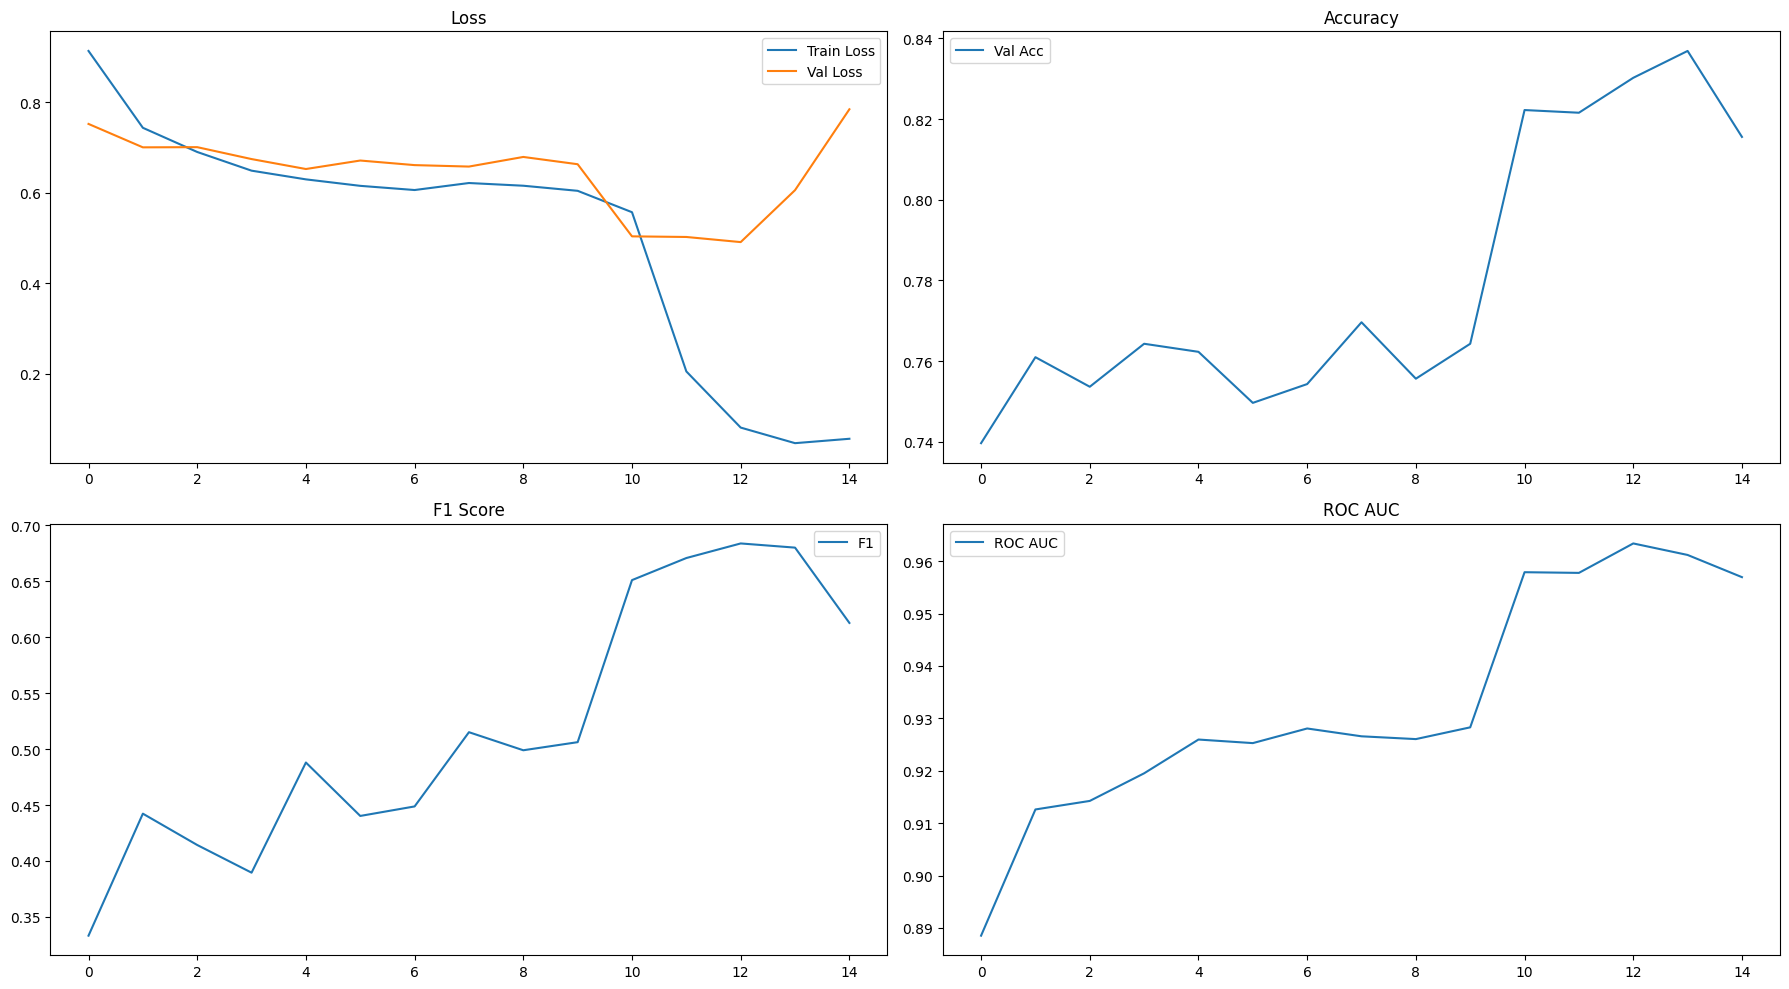

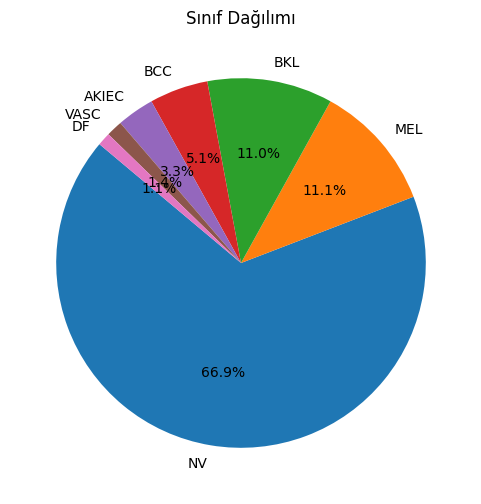

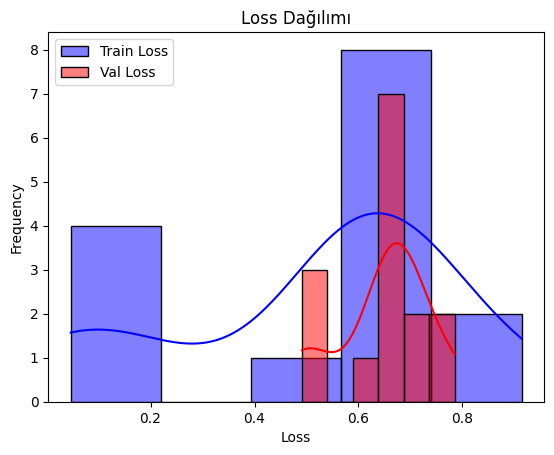

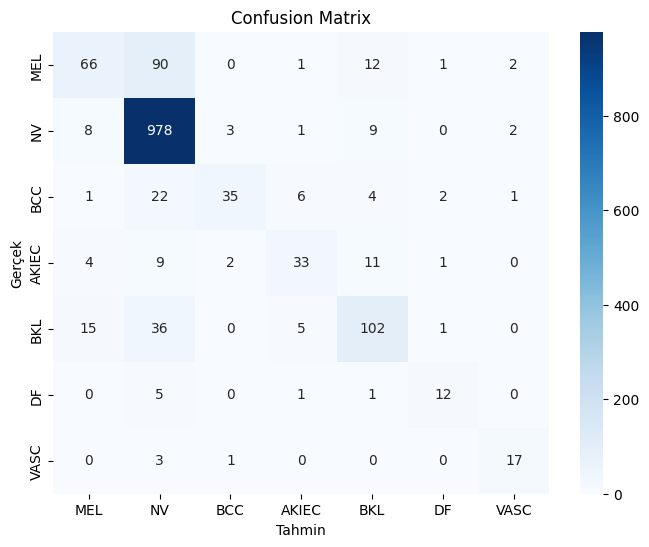

In [ ]:
MODEL_NAME = "resnet18_7class"
BASE_RESULTS = "/content/drive/MyDrive/results"
RESULTS_DIR = f"{BASE_RESULTS}/{MODEL_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(2,2,2)
plt.plot(val_accs,label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(2,2,3)
plt.plot(f1s,label="F1")
plt.legend(); plt.title("F1 Score")

plt.subplot(2,2,4)
plt.plot(rocs,label="ROC AUC")
plt.legend(); plt.title("ROC AUC")

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/training_metrics.png", dpi=300)
plt.show()


class_counts = metadata['dx'].map(lambda x: label_map[x.lower()]).value_counts()
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Sınıf Dağılımı")
plt.savefig(f"{RESULTS_DIR}/class_distribution_pie.png", dpi=300)
plt.show()


sns.histplot(train_losses, color="blue", label="Train Loss", kde=True)
sns.histplot(val_losses, color="red", label="Val Loss", kde=True)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.title("Loss Dağılımı")
plt.legend()
plt.savefig(f"{RESULTS_DIR}/loss_histogram.png", dpi=300)
plt.show()


all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        all_preds.extend(torch.argmax(out,1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.savefig(f"{RESULTS_DIR}/confusion_matrix_heatmap.png", dpi=300)
plt.show()


In [38]:
class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.gradients = None
        self.activations = None

        layer.register_forward_hook(self.forward_hook)
        layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, m, i, o):
        self.activations = o

    def backward_hook(self, m, gi, go):
        self.gradients = go[0]

    def generate(self, x, cls):
        out = self.model(x)
        self.model.zero_grad()
        out[0,cls].backward()

        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam / cam.max()
        return cam


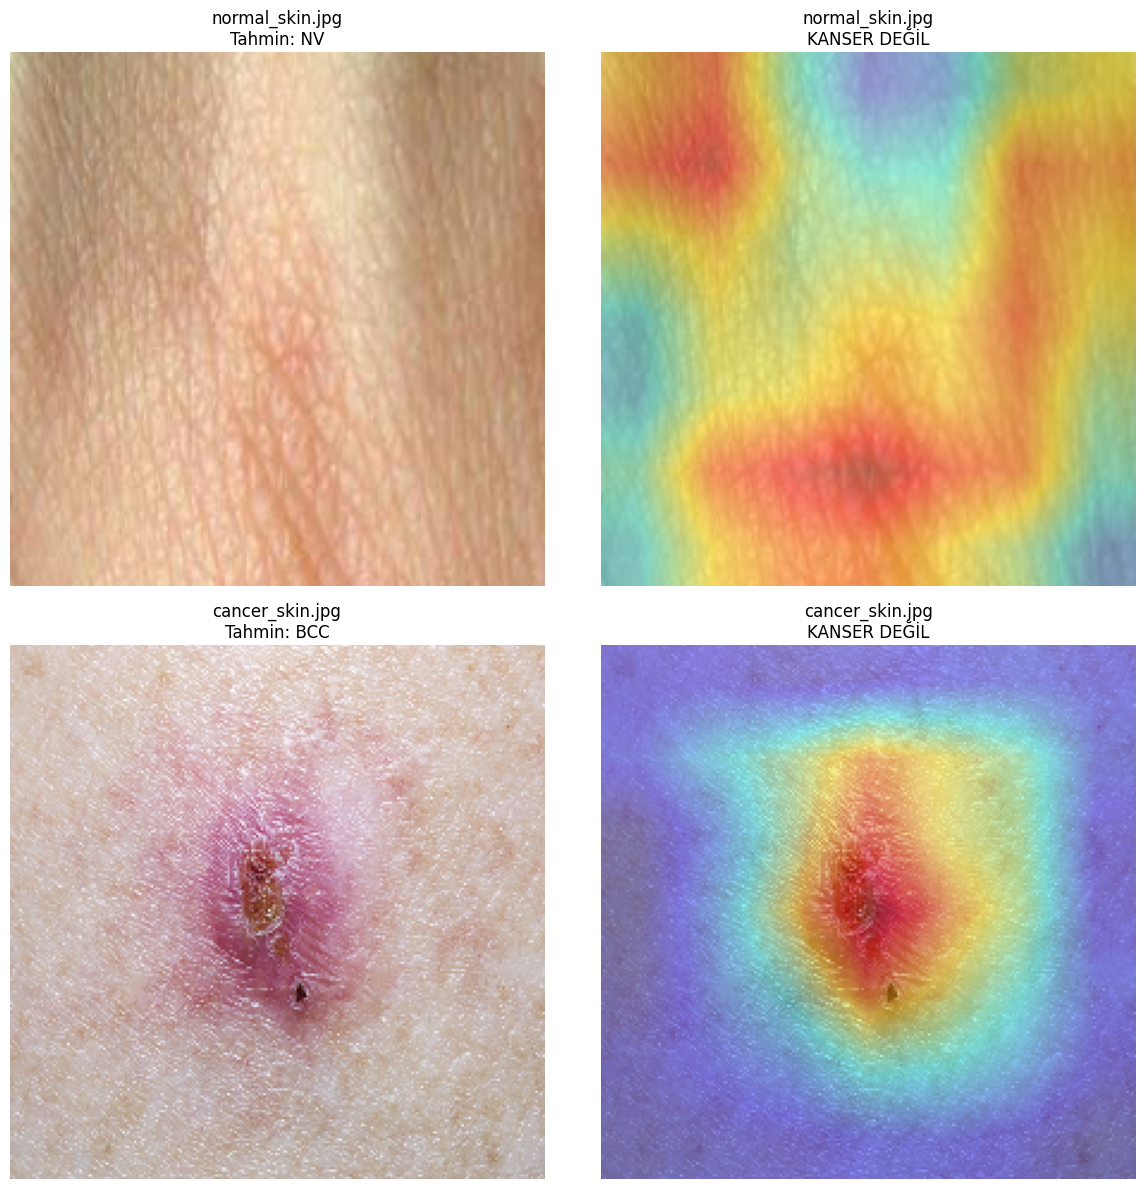

In [42]:


TEST_IMAGE_DIR = "/content/drive/MyDrive/test_gorselleri"
class_names = classes

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = val_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        cls = out.argmax(1).item()

    return x, cls


def analyze_test_images(image_dir):
    model.eval()
    cam = GradCAM(model, model.layer4)


    images = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]

    plt.figure(figsize=(12, len(images)*6))

    for i, img_name in enumerate(images):
        img_path = os.path.join(image_dir, img_name)

        # kanser mi değil mi
        x, cls = predict_image(img_path)
        label_name = class_names[cls]
        cancer_status = "KANSER" if label_name == "MEL" else "KANSER DEĞİL"

        # Grad-CAM
        heatmap = cam.generate(x, cls)[0].detach().cpu().numpy()
        heatmap = cv2.resize(heatmap, (224,224))
        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

        GRADCAM_DIR = f"{RESULTS_DIR}/gradcam"
        os.makedirs(GRADCAM_DIR, exist_ok=True)


        # Orijinal görsel
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224,224))

        overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        cv2.imwrite(f"{GRADCAM_DIR}/{img_name}",overlay)

        # Plot: Orijinal
        plt.subplot(len(images), 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}\nTahmin: {label_name}")
        plt.axis("off")

        # Plot: Grad-CAM
        plt.subplot(len(images), 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}\n{cancer_status}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

analyze_test_images(TEST_IMAGE_DIR)


In [43]:
# kaydetme için

MODEL_NAME = "resnet18"

BASE_RESULTS = "/content/drive/MyDrive/results"
BASE_MODELS  = "/content/drive/MyDrive/models"

RESULTS_DIR = f"{BASE_RESULTS}/{MODEL_NAME}"
GRADCAM_DIR = f"{RESULTS_DIR}/gradcam"
MODEL_PATH  = f"{BASE_MODELS}/{MODEL_NAME}_skin_7class.pth"

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(GRADCAM_DIR, exist_ok=True)
os.makedirs(BASE_MODELS, exist_ok=True)

# Model
torch.save(model.state_dict(), MODEL_PATH)

# Grafik
plt.savefig(
    f"{RESULTS_DIR}/training_metrics.png",
    dpi=300,
    bbox_inches="tight"
)

# CSV
import pandas as pd
df = pd.DataFrame({
    "epoch": range(1, len(train_losses)+1),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc": val_accs,
    "f1": f1s,
    "roc_auc": rocs
})
df.to_csv(f"{RESULTS_DIR}/metrics.csv", index=False)

print("TÜM ÇIKTILAR KAYDEDİLDİ")



TÜM ÇIKTILAR KAYDEDİLDİ


<Figure size 640x480 with 0 Axes>